# Node Embedding and Node Prediction
## 1. Introduction
首先回顾一下上一篇文章关于MessagePassing的GNN的内容。在GNN的MessagePassing里面，每个node代表一个subject，然后edge代表subject之间的关系。而MessagePassing一句话总结就是让每个node的特征(node representation 或node embedding)通过对应的neighbor nodes的信息进行聚集并用于更新每个node
的信息，从而学习到更好的node embedding表达。之后我们可以对学习到的node embedding里面每个node的特征向量输入到classifier里面进行node classification识别subject的类别。除了node classification外，node embedding还能用来做edge classification， graph classification 等任务。

而这次项目的目的是要实现GNN图神经网络并进行实践应用到Cora (scientific publications)科学文献dataset里面，并对每篇文章进行分类和预测文章的类别。这次的项目的大概流程是:
1. Introduction to Cora Dataset: 简单介绍一下Cora论文数据集的构成
2. Data Visualization: 对Cora数据集的node representation 和class 进行可视化
3. Modeling and training: 搭建和训练MLP, GCN, GAT等模型对node 进行classification以及测试
4. Visualize learned node representation: 将学到的node representation进行可视化分析每个类分布的不同
5. Assignment: 尝试其他不同的Dataset看一下不同GNN的效果
6. Conclusion: 总结一下学到什么


## 2. Data Description
这里先来介绍Coras Dataset的内容，Coras Dataset 的解释可以从官网找到: https://linqs.soe.ucsc.edu/data
Coras dataset content:
+ Number of nodes: 2708 nodes. 每个node代表一篇论文
+ Number of edges/links: 5429条无向的边，如果用有向的边表示就是10556条
+ Number of class: 8. 总共有7个类别的论文
+ Dimension of node representation: 1433. 字典的大小为1433每个词用0,1 表示文章有没有那个词. 每篇文章的node representation就有1433

In [40]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='./dataset', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [41]:
data.train_mask,data.y.unique()

(tensor([ True,  True,  True,  ..., False, False, False]),
 tensor([0, 1, 2, 3, 4, 5, 6]))

## 2. Data Visualization
这里简单用TSNE的降维算法把1433 维的node representation降到2维从而来显示每个class的数据的分布, 每种颜色代表一个class。从下面每种颜色的点的分布来看，在学习之前的不同类别的node representation是很难区分开来的，所以很多节点的特征都混在一起

In [42]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color,title=""):
    # convert node data x to TSNE embedding data
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


In [43]:
data.x.shape, data.y.shape

(torch.Size([2708, 1433]), torch.Size([2708]))

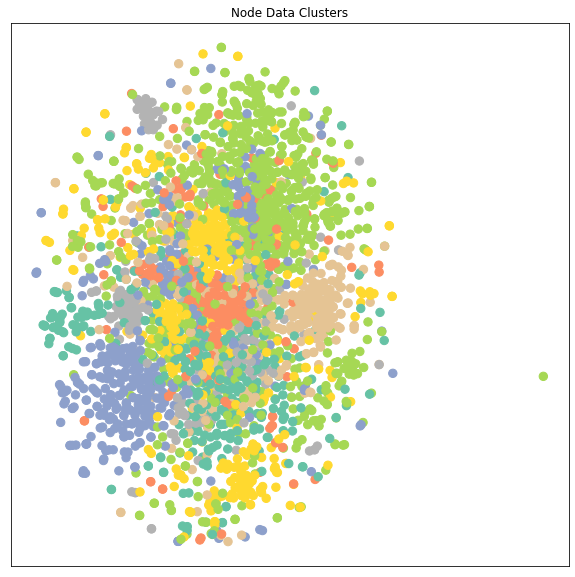

In [44]:
visualize(data.x,data.y,"Node Data Clusters")

## 3. 用不同GNN对node embedding进行学习
这里先简单来设计training, testing 的通用函数, 之后尝试用以下不同的模型进行学习和对比:
+ MLP
+ GNN
+ GAT
+ GraphSAGE

In [133]:
def train(model, criterion, optimizer,data, use_mask=True):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    if use_mask:
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    else:
        loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test(model, data, use_mask=True):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    if use_mask:
        test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    else:
        test_correct = pred == data.y # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / len(data.y)  # Derive ratio of correct predictions.
    return test_acc

### 3.1 MLP

In [46]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, in_channel, classes, hidden_channels,random_seed=12345):
        super(MLP, self).__init__()
        torch.manual_seed(random_seed)
        self.lin1 = Linear(in_channel, hidden_channels)
        self.lin2 = Linear(hidden_channels, classes)

    def forward(self, x, index):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model_mlp = MLP(in_channel = dataset.num_features, classes = dataset.num_classes, hidden_channels=16)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
print("Model Strucutre:")
print(model_mlp)

for epoch in range(1, 201):
    loss = train(model_mlp, criterion, optimizer,data)
    if epoch%20==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print()
test_acc = test(model_mlp,data)
print(f'Test Accuracy: {test_acc:.4f}')

Model Strucutre:
MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch: 020, Loss: 1.7441
Epoch: 040, Loss: 1.2543
Epoch: 060, Loss: 0.8578
Epoch: 080, Loss: 0.6368
Epoch: 100, Loss: 0.5350
Epoch: 120, Loss: 0.4745
Epoch: 140, Loss: 0.4031
Epoch: 160, Loss: 0.3782
Epoch: 180, Loss: 0.4203
Epoch: 200, Loss: 0.3810

Test Accuracy: 0.5900


### 3.2 GCN
GCN Layer 公式如下:

$$
\mathbf{x}_i^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left( \mathbf{\Theta} \cdot \mathbf{x}_j^{(k-1)} \right),
$$

这里一些函数定义如下：
+ $\phi(..)$: message函数GCN一样都是linear projection之后用degree进行normalization
+ $\square(..)$ : aggregate 函数用 add
+ $\gamma(..)$: update 函数是直接将aggregate后的结果输出

这里把MLP里面的linear layer换成是GCN layer

In [49]:
import torch
from torch_geometric.nn import GCNConv
from torch.nn import functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channel,classes, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channel, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model_gcn = GCN(in_channel= dataset.num_features, classes= dataset.num_classes, hidden_channels=16)
print("Model Architecture: ")
print(model_gcn)


optimizer = torch.optim.Adam(model_gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(model_gcn, criterion, optimizer,data)
    if epoch%20==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print()
test_acc = test(model_gcn,data)
print(f'Test Accuracy: {test_acc:.4f}')

Model Architecture: 
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Epoch: 020, Loss: 1.7184
Epoch: 040, Loss: 1.3363
Epoch: 060, Loss: 1.0066
Epoch: 080, Loss: 0.7248
Epoch: 100, Loss: 0.5833
Epoch: 120, Loss: 0.5064
Epoch: 140, Loss: 0.4131
Epoch: 160, Loss: 0.3799
Epoch: 180, Loss: 0.3186
Epoch: 200, Loss: 0.3006

Test Accuracy: 0.8140


### 3.3 GAT (Graph Attention Network)
+ paper link: https://arxiv.org/pdf/1710.10903.pdf
+ Graph Attention Network 的attention公式如下:

$$
\alpha_{i,j} =
\frac{
\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
[\mathbf{W}\mathbf{h}_i \, \Vert \, \mathbf{W}\mathbf{h}_j]
\right)\right)}
{\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
[\mathbf{W}\mathbf{h}_i \, \Vert \, \mathbf{W}\mathbf{h}_k]
\right)\right)}.
$$

节点信息更新
$$
\mathbf{h}_ i^{'} = \sigma(\frac{1}{K} \sum_{k=1}^K\sum_{j \in N(i)} a_{ij}^{k}\mathbf{W}^k\mathbf{h}_{i})
$$

实际上GAT就是在每个节点把邻居的信息聚合时根据邻居节点的node representation和这个节点的node representation的相似度对聚合的信息有侧重地聚合
其中每个参数的代表:
+ $\mathbf{h}_i$: 节点 i的node representation。这个node representation可以是GNN的某一层的输出
+ $\mathbf{W}$: shared linear transformation. 用于每个节点的共享的线性投映矩阵，所有节点都用相同的W进行投映
+ $k \in \mathcal{N}(i) \cup \{ i \}$:  第i个节点的邻居节点(包括第i个节点本身)。
+ $\Vert$: 把两个向量拼接



In [52]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channel, classes, hidden_channels, dropout_r = 0.2):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.dropout_r = dropout_r
        self.conv1 = GATConv(in_channel, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.linear = torch.nn.Linear(hidden_channels,classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=self.dropout_r, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.linear(x)
        return x
    
    
    


model_gat = GAT(in_channel = dataset.num_features, classes = dataset.num_classes, hidden_channels = 16)
optimizer = torch.optim.Adam(model_gat.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
print("Model Strucutre:")
print(model_gat)

for epoch in range(1, 201):
    loss = train(model_gat, criterion, optimizer,data)
    if epoch%20==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print()
test_acc = test(model_gat,data)
print(f'Test Accuracy: {test_acc:.4f}')

Model Strucutre:
GAT(
  (conv1): GATConv(1433, 16, heads=1)
  (conv2): GATConv(16, 16, heads=1)
  (linear): Linear(in_features=16, out_features=7, bias=True)
)
Epoch: 020, Loss: 1.5780
Epoch: 040, Loss: 0.5588
Epoch: 060, Loss: 0.1466
Epoch: 080, Loss: 0.0755
Epoch: 100, Loss: 0.0585
Epoch: 120, Loss: 0.0351
Epoch: 140, Loss: 0.0406
Epoch: 160, Loss: 0.0292
Epoch: 180, Loss: 0.0285
Epoch: 200, Loss: 0.0287

Test Accuracy: 0.7230


**对GAT做一点调参，提一下性能**
+ hidden_channels 用24时比小于16和大于32的时候好
+ dropout=0.8时效果也更好，可能GAT里面的attention的机制容易对一部分特征overfitting
+ epoch设置300更加长些也效果好点
+ 这里调了下参数有了**6%**的提升

In [53]:
model_gat = GAT(in_channel = dataset.num_features, classes = dataset.num_classes, hidden_channels = 24, dropout_r= 0.8)
optimizer = torch.optim.Adam(model_gat.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
print("Model Strucutre:")
print(model_gat)

for epoch in range(1, 301):
    loss = train(model_gat, criterion, optimizer,data)
    if epoch%20==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print()
test_acc = test(model_gat,data)
print(f'Test Accuracy: {test_acc:.4f}')

Model Strucutre:
GAT(
  (conv1): GATConv(1433, 24, heads=1)
  (conv2): GATConv(24, 24, heads=1)
  (linear): Linear(in_features=24, out_features=7, bias=True)
)
Epoch: 020, Loss: 1.6420
Epoch: 040, Loss: 0.7042
Epoch: 060, Loss: 0.4498
Epoch: 080, Loss: 0.2709
Epoch: 100, Loss: 0.2429
Epoch: 120, Loss: 0.1849
Epoch: 140, Loss: 0.2643
Epoch: 160, Loss: 0.1832
Epoch: 180, Loss: 0.2135
Epoch: 200, Loss: 0.1697
Epoch: 220, Loss: 0.1485
Epoch: 240, Loss: 0.1359
Epoch: 260, Loss: 0.1606
Epoch: 280, Loss: 0.1778
Epoch: 300, Loss: 0.1555

Test Accuracy: 0.7810


### 3.4. GraphSAGE (Sample and Aggregate Graph Embedding SAGE)
+ Paper Link: https://arxiv.org/pdf/1706.02216.pdf
+ 其他GNN的node embedding的学习方法都是假设了图里面所有node都是在训练时已经见到的并且有自己的特征数据作为训练集。 而在训练之后，当这些已经见过的node的特征值改变时，可以用GNN对它进行预测。但是实际问题里面，有可能有些node在训练时完全没有见过的(**但是出现时会和其他已经见过的node存在link**)，因此不能在训练时用这些node的数据进行训练(**这个有点像推荐系统的Embedding里面没有见过的userid或itemid的冷启动情况**)。GraphSAGE就是用来解决这个问题
+ GraphSAGE是一种 inductive的representation learning的方法，就是归纳法。它是用于预测之前没有见过的node的embed的ing的特征。它的主要思想是通过学习多个aggregate函数(paper里面提出来mean, LSTM, pooling 三个)，然后这些aggregate函数用neighbor的信息来生成之前没有见过的node的embedding之后再做预测。下面是GraphSAGE的流程图：
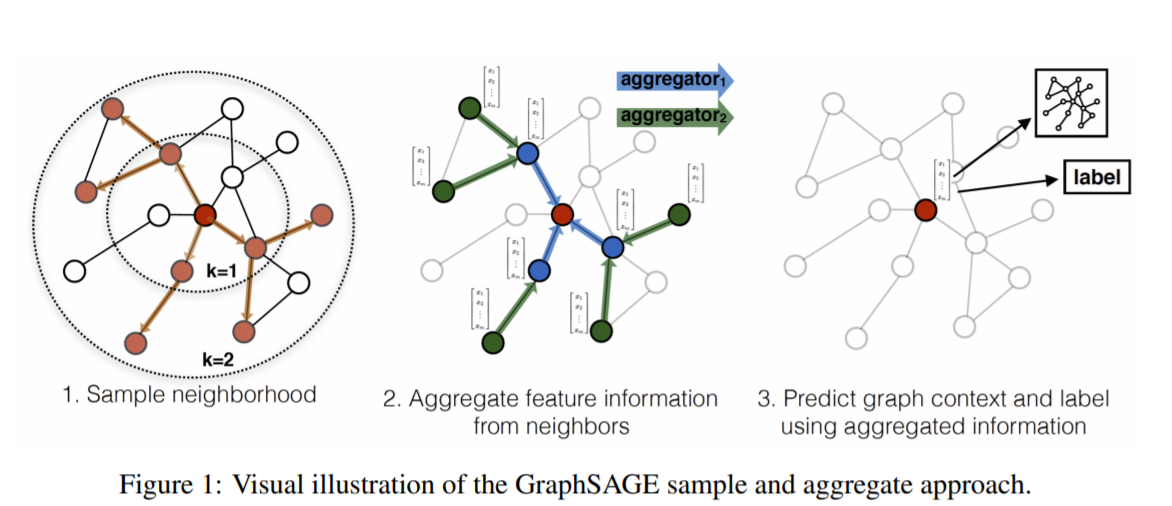

+ GraphSAGE 的node embedding的其中一个生成公式为(还有其他用于生成embedding的aggregate函数公式可以参考原文):
$$
\mathbf{x}_{i}^{'} = \mathbf{W}_{1}x_{i} + \textbf{mean}_{j \in N(i)}(\mathbf{x}_{j})
$$

+ GraphSAGE 的graph-based unsupervised loss function 定义为
$$
\mathbf{J}_{G}(z_{u}) = -log(\sigma(\mathbf{z}_{u}^{T}\mathbf{z}_{v})) - \mathbf{Q} \cdot \mathbf{E}_{v_{n} \in P_{n}(v)}log(\sigma(-\mathbf{z}_{u}^{T}\mathbf{z}_{v_{n}}))
$$

其中:
+ $j \in N(i)$ 为第i个节点的第j个neighbor节点
+ $v$ 是和 $u$ 在定长的random walk采样路径出现的节点
+ $Q$ 是负样本的个数， $P_{n}(v)$ 是负采样的分布
+ $z_{u}$是node representation特征
+ 这里$\sigma()$里面计算的是节点和random walk采样时同时出现的其他节点的相似度。相似度越大，loss越小

+ GraphSAGE 的计算embedding算法流程如下:
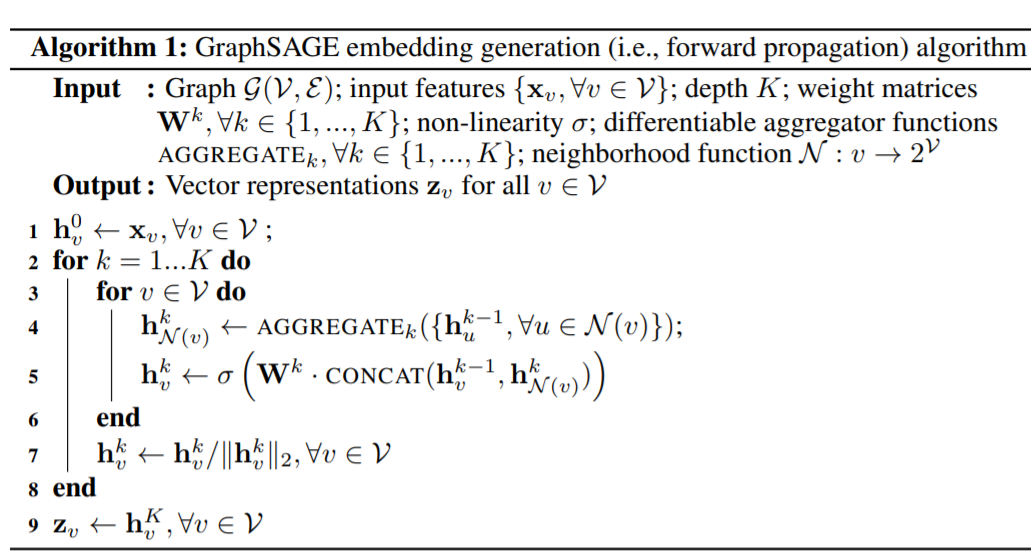



In [54]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv

class SAGE(torch.nn.Module):
    def __init__(self, in_channel, classes, hidden_channels, dropout_r = 0.2):
        super(SAGE, self).__init__()
        torch.manual_seed(12345)
        self.dropout_r = dropout_r
        self.conv1 = SAGEConv(in_channel, hidden_channels,normalize=True)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels,normalize=True)
        self.linear = torch.nn.Linear(hidden_channels,classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=self.dropout_r, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.linear(x)
        return x
    
    
    


model_sage = SAGE(in_channel = dataset.num_features, classes = dataset.num_classes, hidden_channels = 24,dropout_r= 0.5)
optimizer = torch.optim.Adam(model_sage.parameters(), lr=0.03, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
print("Model Strucutre:")
print(model_sage)

for epoch in range(1, 201):
    loss = train(model_sage, criterion, optimizer,data)
    if epoch%20==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print()
test_acc = test(model_sage,data)
print(f'Test Accuracy: {test_acc:.4f}')

Model Strucutre:
SAGE(
  (conv1): SAGEConv(1433, 24)
  (conv2): SAGEConv(24, 24)
  (linear): Linear(in_features=24, out_features=7, bias=True)
)
Epoch: 020, Loss: 0.3678
Epoch: 040, Loss: 0.0956
Epoch: 060, Loss: 0.0435
Epoch: 080, Loss: 0.0424
Epoch: 100, Loss: 0.1066
Epoch: 120, Loss: 0.0316
Epoch: 140, Loss: 0.0474
Epoch: 160, Loss: 0.0640
Epoch: 180, Loss: 0.1417
Epoch: 200, Loss: 0.0442

Test Accuracy: 0.7800


## 3.5 Node Representation Cluster Visualization

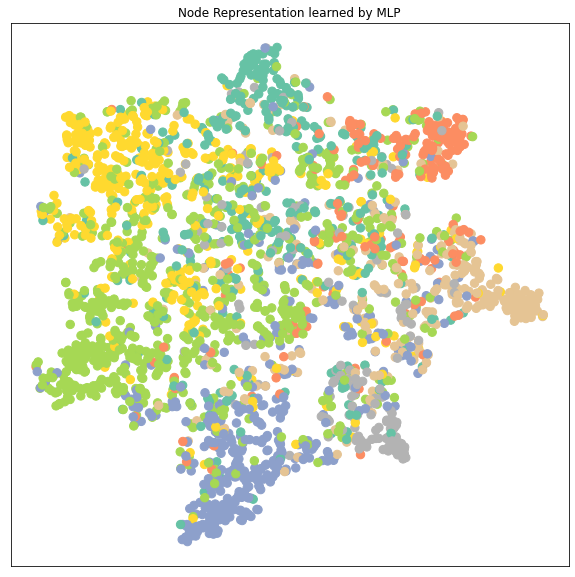

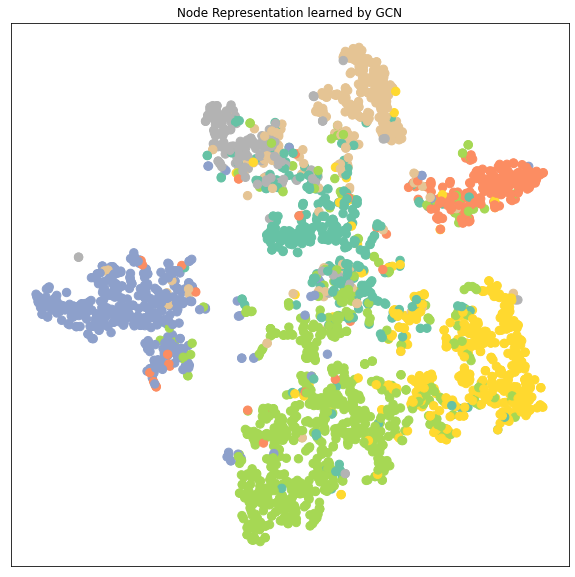

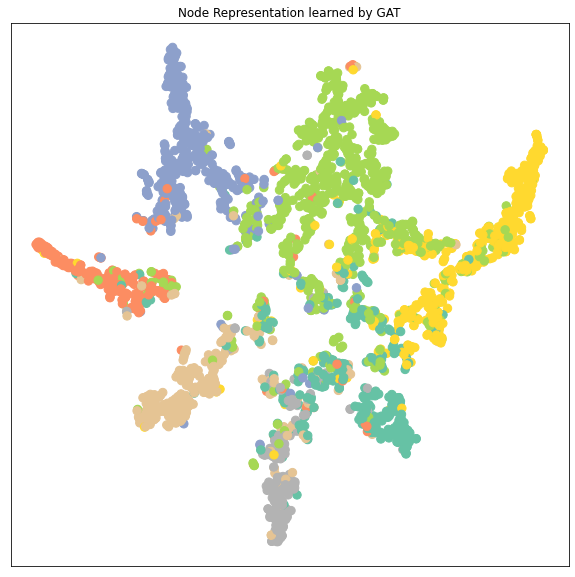

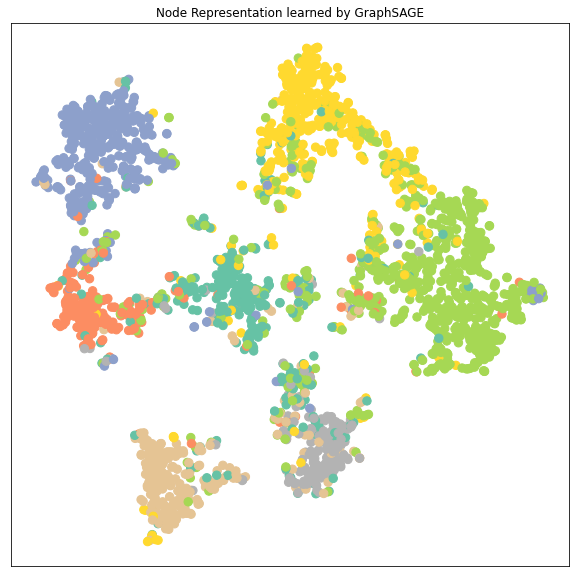

In [55]:
models = {"MLP":model_mlp, "GCN":model_gcn,"GAT":model_gat, "GraphSAGE":model_sage}
for k in models.keys():
    model = models[k]
    out = model(data.x, data.edge_index)
    title = f"Node Representation learned by {k}"
    visualize(out, data.y, title)

## 4. Assignment
- 此篇文章涉及的代码可见于`codes/learn_node_representation.ipynb`，请参照这份代码使用[PyG中不同的图卷积模块](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers)在[PyG的不同数据集](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)上实现节点分类或回归任务。

### 4.1 Dataset选择
+ Pubmed: https://arxiv.org/abs/1603.08861
+ Citeseer: https://arxiv.org/abs/1603.08861
+ CitationFull： https://arxiv.org/abs/1707.03815
+ 本来想尝试其他数据，但是其他数据集太大训练起来很慢特征，后期有时间再试试看

In [104]:
# dataset used by GAT
from torch_geometric.datasets import PPI, Reddit,NELL,QM7b,CitationFull,AMiner
pubmed_dataset = Planetoid(root='./dataset', name='Pubmed', transform=NormalizeFeatures())
Citeseer_dataset = Planetoid(root='./dataset', name='CITESEER', transform=NormalizeFeatures())
CitationFull_dataset =CitationFull(root='./dataset',name="DBLP",transform=NormalizeFeatures())
# PPI_train = PPI(root='./dataset',  split='train',transform=NormalizeFeatures())
# PPI_test = PPI(root='./dataset',  split='test',transform=NormalizeFeatures())
# PPI_dataset = {'train':PPI_train,"test":PPI_test}


# AMiner_dataset = AMiner(root='./dataset',transform=NormalizeFeatures())
#QM7b_dataset = QM7b(root='./dataset', transform=NormalizeFeatures())
# Reddit_dataset = Reddit(root='./dataset', transform=NormalizeFeatures())
# NELL_dataset = NELL(root='./dataset', transform=NormalizeFeatures())

Extracting dataset/ppi.zip


In [126]:
import pandas as pd
#mydatasets = {"Pubmed":pubmed_dataset, "Citeseer":Citeseer_dataset, "Reddit":Reddit_dataset,"NELL":NELL_dataset}
mydatasets = {"CitationFull":CitationFull_dataset,"Pubmed":pubmed_dataset, "Citeseer":Citeseer_dataset}
df = pd.DataFrame(columns={"dataset","#graphs","#features","#classes"})

dic = {"dataset":[],"#graphs":[],"#features":[],"#classes":[],"#nodes":[],"#edges":[],"Has_isolated_nodes":[],"undirected":[]}
for k in mydatasets.keys():
    tmp = {k:mydatasets[k]}
    if k in ["PPI"]:
        tmp = mydatasets[k]
    for key in tmp.keys():
        dataset = tmp[key]
        print("dataset: ",key)
        dic['dataset'].append(key)
        dic['#graphs'].append(len(dataset))
        dic['#features'].append(dataset.num_features)
        dic['#classes'].append(dataset.num_classes)
        data = dataset[0]
        dic['#nodes'].append(data.num_nodes)
        dic['#edges'].append(data.num_edges)
        dic['Has_isolated_nodes'].append(data.contains_isolated_nodes())
        dic['undirected'].append(data.is_undirected())

data_stat = pd.DataFrame(dic)
data_stat.T

# print()
# print(f'Dataset: {dataset}:')
# print('======================')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

# data = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('======================')

# # Gather some statistics about the graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')

dataset:  CitationFull
dataset:  Pubmed
dataset:  Citeseer


,0,1,2
dataset,CitationFull,Pubmed,Citeseer
#graphs,1,1,1
#features,1639,500,3703
#classes,4,3,6
#nodes,17716,19717,3327
#edges,105734,88648,9104
Has_isolated_nodes,False,False,True
undirected,True,True,True


In [130]:
# KarateClub_dataset[0]
# ! du -h ./dataset/



In [134]:
models = {}

def train_models(models, datasets):
    res = {}
    mymodels = {}
    for key in datasets.keys():
        if key in ["CitationFull"]:
            dataset = datasets[key]
            testset = datasets[key]
        else:
            dataset = datasets[key]
            testset= None
        data = dataset[0]
        if key not in res.keys():
            res[key] = {}
        if key not in models.keys():
            mymodels[key] = {}
            
        model_mlp2 = MLP(in_channel = dataset.num_features, classes = dataset.num_classes,hidden_channels=16)
        model_gcn2 = GCN(in_channel = dataset.num_features, classes = dataset.num_classes,hidden_channels=16)
        model_sage2 = SAGE(in_channel = dataset.num_features, classes = dataset.num_classes,hidden_channels = 24,dropout_r= 0.5)
        model_gat2 = GAT(in_channel = dataset.num_features, classes = dataset.num_classes,hidden_channels = 24, dropout_r= 0.8)
        models = {"MLP":model_mlp2, "GCN":model_gcn2,"GAT":model_gat2, "GraphSAGE":model_sage2}
        mymodels[key] = models
        for name, model in models.items():
            if name not in res[key].keys():
                res[key][name] =None    
            print(f"Dataset: {key}, model: {name}")
            optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()
            #print("Model Strucutre:")
            #print(model)
            for epoch in range(1, 201):
                use_test_mask = True if testset== None else False
                loss = train(model, criterion, optimizer,data,use_test_mask)
                if epoch%20==0:
                    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            print()
            use_test_mask = True if testset== None else False
            test_acc = test(model,data,use_test_mask)
            print(f'Test Accuracy: {test_acc:.4f}')
            res[key][name] = test_acc
    return pd.DataFrame(res), mymodels

In [135]:
test_results, trained_models = train_models(models, mydatasets)
test_results

Dataset: CitationFull, model: MLP
Epoch: 020, Loss: 0.9961
Epoch: 040, Loss: 0.8182
Epoch: 060, Loss: 0.7515
Epoch: 080, Loss: 0.7192
Epoch: 100, Loss: 0.6986
Epoch: 120, Loss: 0.6905
Epoch: 140, Loss: 0.6799
Epoch: 160, Loss: 0.6746
Epoch: 180, Loss: 0.6669
Epoch: 200, Loss: 0.6673

Test Accuracy: 0.8128
Dataset: CitationFull, model: GCN
Epoch: 020, Loss: 0.7686
Epoch: 040, Loss: 0.5725
Epoch: 060, Loss: 0.5072
Epoch: 080, Loss: 0.4807
Epoch: 100, Loss: 0.4712
Epoch: 120, Loss: 0.4601
Epoch: 140, Loss: 0.4548
Epoch: 160, Loss: 0.4475
Epoch: 180, Loss: 0.4489
Epoch: 200, Loss: 0.4439

Test Accuracy: 0.8606
Dataset: CitationFull, model: GAT
Epoch: 020, Loss: 0.7240
Epoch: 040, Loss: 0.5830
Epoch: 060, Loss: 0.4896
Epoch: 080, Loss: 0.4724
Epoch: 100, Loss: 0.4547
Epoch: 120, Loss: 0.4440
Epoch: 140, Loss: 0.4313
Epoch: 160, Loss: 0.4150
Epoch: 180, Loss: 0.4025
Epoch: 200, Loss: 0.3877

Test Accuracy: 0.8818
Dataset: CitationFull, model: GraphSAGE
Epoch: 020, Loss: 0.4138
Epoch: 040, Lo

,CitationFull,Pubmed,Citeseer
MLP,0.812768,0.728,0.591
GCN,0.860634,0.793,0.701
GAT,0.881802,0.714,0.653
GraphSAGE,0.969011,0.770,0.672


## Conclusion
+ 和以往的像图片文本之类的数据不同，图的数据的训练的不同点有下面几个
    - 除了要输入节点的数据特征外，还要输入edge作为关联的数据。
    - 另外GNN在训练时是可以同时更新多个不同node的embedding。
    - GNN训练时更加像NLP的训练方法，都是把一部分的node（在NLP里面是word token）mask掉并对这部分内容(node或者link)预测
    - 另外在node classification里面因为GNN输入是图，输出也是转换后学习后的图(图里的每个node的值代表这个node所属的class)，可以一下子把所有要预测的node进行预测。不过也可以通过mask的形式在图里面采样进行分batch训练
+ 另外在上面实验中可以看到，在相同配置中GCN要把GAT和GraphSAGE好，GAT比较容易overfit，而GraphSAGE训练比较慢在训练node embedding时设计到两个循环
+ 当node embedding训练得好的时候，不同的类的node embedding特征很容易被区别开来，相同类的node的特征会内聚而不同类的特征会远离，这个其实和普通的NN分类器里面提取的特征一样，比较正常。
    

## Reference
- Datawhale:https://github.com/datawhalechina/team-learning-nlp/blob/master/GNN/Markdown%E7%89%88%E6%9C%AC/5-%E5%9F%BA%E4%BA%8E%E5%9B%BE%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E7%9A%84%E8%8A%82%E7%82%B9%E8%A1%A8%E5%BE%81%E5%AD%A6%E4%B9%A0.md 
- 知乎： https://zhuanlan.zhihu.com/p/106706203
- PyG中内置的数据转换方法：[torch-geometric-transforms](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch-geometric-transforms)
- 一个可视化高纬数据的工具：[t-distributed Stochastic Neighbor Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
- 提出GCN的论文：[Semi-supervised Classification with Graph Convolutional Network](https://arxiv.org/abs/1609.02907)
- GCNConv官方文档：[torch_geometric.nn.conv.GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)
- 提出GAT的论文： [Graph Attention Networks](https://arxiv.org/abs/1710.10903)



In [ ]:
# 基于图神经网络的节点表征学习

## 引言

在图节点预测或边预测任务中，首先需要生成节点表征（Node Representation）。**我们使用图神经网络来生成节点表征，并通过基于监督学习的对图神经网络的训练，使得图神经网络学会产生高质量的节点表征**。**高质量的节点表征能够用于衡量节点的相似性，同时高质量的节点表征也是准确分类节点的前提。**

本节中，我们将**学习实现多层图神经网络的方法**，并以节点分类任务为例，**学习训练图神经网络的一般过程**。我们将以`Cora `数据集为例子进行说明，`Cora `是一个论文引用网络，节点代表论文，如果两篇论文存在引用关系，则对应的两个节点之间存在边，各节点的属性都是一个1433维的词包特征向量。我们的任务是预测各篇论文的类别（共7类）。我们还将对MLP和GCN, GAT（两个知名度很高的图神经网络）三类神经网络在节点分类任务中的表现进行比较分析，以此来展现图神经网络的强大和论证图神经网络强于普通深度神经网络的原因。

此节内容安排如下：

1. 首先，我们要做一些准备工作，即**获取并分析数据集**、**构建一个方法用于分析节点表征的分布**。
2. 然后，我们**考察MLP神经网络用于节点分类的表现**，并**观察基于MLP神经网络学习到的节点表征的分布**。
3. 接着，我们**逐一介绍GCN, GAT这两个图神经网络的理论、对比它们在节点分类任务中的表现以及它们学习到的节点表征的质量**。
4. 最后，我们**比较三者在节点表征学习能力上的差异**。

## 准备工作

### 获取并分析数据集

```python
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='dataset', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

```

我们可以看到，`Cora`图拥有2,708个节点和10,556条边，平均节点度为3.9，训练集仅使用了140个节点，占整体的5%。我们还可以看到，这个图是无向图，不存在孤立的节点。

**数据转换（transform）在将数据输入到神经网络之前修改数据，这一功能可用于实现数据规范化或数据增强**。在此例子中，我们使用[`NormalizeFeatures`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeature)进行节点特征归一化，使各节点特征总和为`1`。其他的数据转换方法请参阅[torch-geometric-transforms](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch-geometric-transforms)。

### 可视化节点表征分布的方法

```python
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

```

我们先利用[**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)方法将高维的节点表征映射到二维平面空间，然后在二维平面画出节点，这样我们就实现了节点表征分布的可视化。

## 使用MLP神经网络进行节点分类

理论上，我们应该能够仅根据文章的内容，即它的词包特征表征（bag-of-words feature representation）来推断文章的类别，而无需考虑文章之间的任何关系信息。接下来，让我们通过构建一个简单的MLP神经网络来验证这一点。此神经网络只对输入节点的表征做变换，它在所有节点之间共享权重。

### MLP神经网络的构造

```python
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

```

我们的MLP由两个线程层、一个`ReLU`非线性层和一个`dropout`操作组成。第一个线程层将1433维的节点表征嵌入（embedding）到低维空间中（`hidden_channels=16`），第二个线性层将节点表征嵌入到类别空间中（`num_classes=7`）。

### MLP神经网络的训练

我们利用**交叉熵损失**和**Adam优化器**来训练这个简单的MLP神经网络。

```python
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

```

### MLP神经网络的测试

训练完模型后，我们可以通过测试来检验这个简单的MLP神经网络在测试集上的表现。

```python
def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')
```

正如我们所看到的，我们的MLP表现相当糟糕，只有大约59%的测试准确性。

**为什么MLP没有表现得更好呢？**其中一个重要原因是，用于训练此神经网络的有标签节点数量过少，此神经网络被过拟合，它对未见过的节点泛化能力很差。

## 卷积图神经网络（GCN）

### GCN的定义

GCN 来源于论文“[Semi-supervised Classification with Graph Convolutional Network](https://arxiv.org/abs/1609.02907)”，其数学定义为，
$$
\mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},
$$
其中$\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$表示插入自环的邻接矩阵（使得每一个节点都有一条边连接到自身），$\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}$表示$\mathbf{\hat{A}}$的对角线度矩阵（对角线元素为对应节点的度，其余元素为0）。邻接矩阵可以包括不为$1$的值，当邻接矩阵不为`{0,1}`值时，表示邻接矩阵存储的是边的权重。$\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2}$是对称归一化矩阵，它的节点式表述为：
$$
\mathbf{x}^{\prime}_i = \mathbf{\Theta} \sum_{j \in \mathcal{N}(v) \cup
\{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j \hat{d}_i}} \mathbf{x}_j
$$
其中，$\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}$，$e_{j,i}$表示从源节点$j$到目标节点$i$的边的对称归一化系数（默认值为1.0）。

### PyG中`GCNConv` 模块说明

`GCNConv`构造函数接口：

```python
GCNConv(in_channels: int, out_channels: int, improved: bool = False, cached: bool = False, add_self_loops: bool = True, normalize: bool = True, bias: bool = True, **kwargs)
```

其中：

- `in_channels `：输入数据维度；
- `out_channels `：输出数据维度；
- `improved `：如果为`true`，$\mathbf{\hat{A}} = \mathbf{A} + 2\mathbf{I}$，其目的在于增强中心节点自身信息；
- `cached `：是否存储$\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}} \mathbf{\hat{D}}^{-1/2}$的计算结果以便后续使用，这个参数只应在归纳学习（transductive learning）的场景中设置为`true`（归纳学习可以简单理解为在训练、验证、测试、推理（inference）四个阶段都只使用一个数据集）；
- `add_self_loops `：是否在邻接矩阵中增加自环边；
- `normalize `：是否添加自环边并在运行中计算对称归一化系数；
- `bias `：是否包含偏置项。

详细内容请大家参阅[GCNConv官方文档](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)。

### GCN图神经网络的构造

将上面例子中的`torch.nn.Linear`替换成`torch_geometric.nn.GCNConv`，我们就可以得到一个GCN图神经网络，如下方代码所示：

```python
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

```

### 可视化由未经训练的GCN图神经网络生成的节点表征

代码如下所示：

```python
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)
```

经过`visualize`函数的处理，7维特征的节点被映射到2维的平面上。我们会惊喜地看到“同类节点群聚”的现象。

![image-20210526214252415](images/image-20210526214252415.png)

### GCN图神经网络的训练

通过下方的代码我们可实现GCN图神经网络的训练：

```python
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

```

### GCN图神经网络的测试

在训练过程结束后，我们检测GCN图神经网络在测试集上的准确性：

```python
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')
```

通过简单地将`torch.nn.Linear`替换成`torch_geometric.nn.GCNConv`，我们可以取得81.4%的测试准确率！与前面的仅获得59%的测试准确率的MLP图神经网络相比，GCN图神经网络准确性要高得多。这表明**节点的邻接信息在取得更好的准确率方面起着关键作用**。

### 可视化由训练后的GCN图神经网络生成的节点表征

最后我们可视化训练后的GCN图神经网络生成的节点表征，我们会发现“同类节点群聚”的现象更加明显了。这意味着在训练后，GCN图神经网络生成的节点表征质量更高了。
```python
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)
```

![image-20210526214436051](images/image-20210526214436051.png)

## 图注意力神经网络（GAT）

### GAT的定义

图注意神经网络（GAT）来源于论文 [Graph Attention Networks](https://arxiv.org/abs/1710.10903)。其数学定义为，
$$
\mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
\sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},
$$
其中注意力系数$\alpha_{i,j}$的计算方法为，
$$
\alpha_{i,j} =
\frac{
\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
\right)\right)}
{\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
\right)\right)}.
$$
### PyG中`GATConv` 模块说明

`GATConv`构造函数接口：

```python
GATConv(in_channels: Union[int, Tuple[int, int]], out_channels: int, heads: int = 1, concat: bool = True, negative_slope: float = 0.2, dropout: float = 0.0, add_self_loops: bool = True, bias: bool = True, **kwargs)
```

其中：

- `in_channels `：输入数据维度；
- `out_channels `：输出数据维度；
- `heads `：在`GATConv`使用多少个注意力模型（Number of multi-head-attentions）；
- `concat `：如为`true`，不同注意力模型得到的节点表征被拼接到一起（表征维度翻倍），否则对不同注意力模型得到的节点表征求均值；

详细内容请大家参阅[GATConv官方文档](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv)

### GAT图神经网络的构造

将MLP神经网络例子中的`torch.nn.Linear`替换成`torch_geometric.nn.GATConv`，来实现GAT图神经网络的构造，如下方代码所示：

```python
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

```

基于GAT图神经网络的训练和测试，与基于GCN图神经网络的训练和测试相同，此处不再赘述。

## 结语

在节点表征的学习中，MLP神经网络只考虑了节点自身属性，**忽略了节点之间的连接关系**，它的结果是最差的；而GCN图神经网络与GAT图神经网络，**同时考虑了节点自身信息与周围邻接节点的信息**，因此它们的结果都优于MLP神经网络。也就是说，对周围邻接节点的信息的考虑，是图神经网络由于普通深度神经网络的原因。

GCN图神经网络与GAT图神经网络的相同点为：

- 它们都**遵循消息传递范式**；
- 在邻接节点信息变换阶段，它们都对邻接节点做归一化和线性变换；
- 在邻接节点信息聚合阶段，它们都将变换后的邻接节点信息做求和聚合；
- 在中心节点信息变换阶段，它们都只是简单返回邻接节点信息聚合阶段的聚合结果。

GCN图神经网络与GAT图神经网络的区别在于邻接节点信息聚合过程中的**归一化方法不同**：

- 前者根据中心节点与邻接节点的度计算归一化系数，后者根据中心节点与邻接节点的相似度计算归一化系数。
- 前者的归一化方式依赖于图的拓扑结构：不同的节点会有不同的度，同时不同节点的邻接节点的度也不同，于是在一些应用中GCN图神经网络会表现出较差的泛化能力。
- 后者的归一化方式依赖于中心节点与邻接节点的相似度，相似度是训练得到的，因此不受图的拓扑结构的影响，在不同的任务中都会有较好的泛化表现。

## 作业

- 此篇文章涉及的代码可见于`codes/learn_node_representation.ipynb`，请参照这份代码使用[PyG中不同的图卷积模块](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers)在[PyG的不同数据集](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)上实现节点分类或回归任务。

## 参考文献

- PyG中内置的数据转换方法：[torch-geometric-transforms](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch-geometric-transforms)
- 一个可视化高纬数据的工具：[t-distributed Stochastic Neighbor Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
- 提出GCN的论文：[Semi-supervised Classification with Graph Convolutional Network](https://arxiv.org/abs/1609.02907)
- GCNConv官方文档：[torch_geometric.nn.conv.GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)
- 提出GAT的论文： [Graph Attention Networks](https://arxiv.org/abs/1710.10903)

